In this notebook i will follow the instructions in this video and adapt based on or proect and preferences : https://www.youtube.com/watch?v=p_6kULimQvI

In [219]:
# Importing the libraries
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import GRU, Dense

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU

import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error


from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [220]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [221]:
# root_path = '../input/cs.csv' # local file
root_path = '..\cleaned-data\ethereum-pools-volume-cleaned.csv'

In [222]:
stock_df = pd.read_csv(root_path)
stock_df.head()

,daily_volume,time,total_volume,Pool-Name,running_total_by_pool
0,8.568270e+04,2021-05-05T00:00:00+00:00,8.568270e+04,DAI / ETH 0.05% fee,8.568270e+04
1,1.431467e+06,2021-05-06T00:00:00+00:00,1.517149e+06,DAI / ETH 0.05% fee,1.517149e+06
2,8.459799e+06,2021-05-07T00:00:00+00:00,9.976948e+06,DAI / ETH 0.05% fee,9.976948e+06
3,6.341874e+06,2021-05-08T00:00:00+00:00,1.631882e+07,DAI / ETH 0.05% fee,1.631882e+07
4,2.707201e+05,2021-05-09T00:00:00+00:00,1.658954e+07,DAI / ETH 0.05% fee,1.658954e+07


In [223]:
stock_df = stock_df.rename(columns={'Pool-Name': 'pool_name'})
stock_df.head()

,daily_volume,time,total_volume,pool_name,running_total_by_pool
0,8.568270e+04,2021-05-05T00:00:00+00:00,8.568270e+04,DAI / ETH 0.05% fee,8.568270e+04
1,1.431467e+06,2021-05-06T00:00:00+00:00,1.517149e+06,DAI / ETH 0.05% fee,1.517149e+06
2,8.459799e+06,2021-05-07T00:00:00+00:00,9.976948e+06,DAI / ETH 0.05% fee,9.976948e+06
3,6.341874e+06,2021-05-08T00:00:00+00:00,1.631882e+07,DAI / ETH 0.05% fee,1.631882e+07
4,2.707201e+05,2021-05-09T00:00:00+00:00,1.658954e+07,DAI / ETH 0.05% fee,1.658954e+07


In [224]:
# Loading the data
dataset = pd.read_csv('..\cleaned-data\ethereum-pools-volume-cleaned.csv')

In [225]:
# Split column 'Pool-Name' into three columns: 'Token_1', 'Token_2' and 'Fee's'
crypto_info = dataset['Pool-Name'].str.split(' ', n=2, expand=True)
dataset['Token_1'] = crypto_info[0]
dataset['Token_2'] = crypto_info[2].str.split(' ', n=1, expand=True)[0]

# Create columns for each rate type
dataset['fee_0.01%'] = 0
dataset['fee_0.05%'] = 0
dataset['fee_0.3%'] = 0
dataset['fee_1%'] = 0

# Assign the correct values to the fee columns
dataset.loc[dataset['Pool-Name'].str.contains('0.01%'), 'fee_0.01%'] = 1
dataset.loc[dataset['Pool-Name'].str.contains('0.05%'), 'fee_0.05%'] = 1
dataset.loc[dataset['Pool-Name'].str.contains('0.3%'), 'fee_0.3%'] = 1
dataset.loc[dataset['Pool-Name'].str.contains('1%'), 'fee_1%'] = 1

# printing to see the results
dataset

,daily_volume,time,total_volume,Pool-Name,running_total_by_pool,Token_1,Token_2,fee_0.01%,fee_0.05%,fee_0.3%,fee_1%
0,8.568270e+04,2021-05-05T00:00:00+00:00,8.568270e+04,DAI / ETH 0.05% fee,8.568270e+04,DAI,ETH,0,1,0,0
1,1.431467e+06,2021-05-06T00:00:00+00:00,1.517149e+06,DAI / ETH 0.05% fee,1.517149e+06,DAI,ETH,0,1,0,0
2,8.459799e+06,2021-05-07T00:00:00+00:00,9.976948e+06,DAI / ETH 0.05% fee,9.976948e+06,DAI,ETH,0,1,0,0
3,6.341874e+06,2021-05-08T00:00:00+00:00,1.631882e+07,DAI / ETH 0.05% fee,1.631882e+07,DAI,ETH,0,1,0,0
4,2.707201e+05,2021-05-09T00:00:00+00:00,1.658954e+07,DAI / ETH 0.05% fee,1.658954e+07,DAI,ETH,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
15043,1.432193e+08,2023-05-22T00:00:00+00:00,3.750031e+11,ETH / USDC 0.05% fee,3.750031e+11,ETH,USDC,0,1,0,0
15044,1.514438e+08,2023-05-23T00:00:00+00:00,3.751546e+11,ETH / USDC 0.05% fee,3.751546e+11,ETH,USDC,0,1,0,0
15045,1.956226e+08,2023-05-24T00:00:00+00:00,3.753502e+11,ETH / USDC 0.05% fee,3.753502e+11,ETH,USDC,0,1,0,0
15046,1.432230e+08,2023-05-25T00:00:00+00:00,3.754934e+11,ETH / USDC 0.05% fee,3.754934e+11,ETH,USDC,0,1,0,0


In [226]:
# Save the new DataFrame to a CSV file
dataset.to_csv('new_dataset.csv', index=False)

In [227]:
# Token-to-number mapping dictionary
token_dict = {'DAI': 0, 'ETH': 1, 'LUSD': 2, 'USDC': 3, 'UDT': 4, 'MATIC': 5, 'WBTC': 6, 'USDT': 7, 'LINK': 8, 'OP': 9, 'ARB': 10, 'WETH': 11, 'BUSD': 12, 'BNB': 13}

# Mapping tokens to numbers in column 'Token_1'
dataset['Token_1'] = dataset['Token_1'].map(token_dict)

# Mapping tokens to numbers in column 'Token_2'
dataset['Token_2'] = dataset['Token_2'].map(token_dict)

dataset


,daily_volume,time,total_volume,Pool-Name,running_total_by_pool,Token_1,Token_2,fee_0.01%,fee_0.05%,fee_0.3%,fee_1%
0,8.568270e+04,2021-05-05T00:00:00+00:00,8.568270e+04,DAI / ETH 0.05% fee,8.568270e+04,0,1,0,1,0,0
1,1.431467e+06,2021-05-06T00:00:00+00:00,1.517149e+06,DAI / ETH 0.05% fee,1.517149e+06,0,1,0,1,0,0
2,8.459799e+06,2021-05-07T00:00:00+00:00,9.976948e+06,DAI / ETH 0.05% fee,9.976948e+06,0,1,0,1,0,0
3,6.341874e+06,2021-05-08T00:00:00+00:00,1.631882e+07,DAI / ETH 0.05% fee,1.631882e+07,0,1,0,1,0,0
4,2.707201e+05,2021-05-09T00:00:00+00:00,1.658954e+07,DAI / ETH 0.05% fee,1.658954e+07,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
15043,1.432193e+08,2023-05-22T00:00:00+00:00,3.750031e+11,ETH / USDC 0.05% fee,3.750031e+11,1,3,0,1,0,0
15044,1.514438e+08,2023-05-23T00:00:00+00:00,3.751546e+11,ETH / USDC 0.05% fee,3.751546e+11,1,3,0,1,0,0
15045,1.956226e+08,2023-05-24T00:00:00+00:00,3.753502e+11,ETH / USDC 0.05% fee,3.753502e+11,1,3,0,1,0,0
15046,1.432230e+08,2023-05-25T00:00:00+00:00,3.754934e+11,ETH / USDC 0.05% fee,3.754934e+11,1,3,0,1,0,0


In [228]:
# Removing the column 'Pool-Name' because the infos are now splited
dataset = dataset.drop(columns=['Pool-Name'])
dataset

,daily_volume,time,total_volume,running_total_by_pool,Token_1,Token_2,fee_0.01%,fee_0.05%,fee_0.3%,fee_1%
0,8.568270e+04,2021-05-05T00:00:00+00:00,8.568270e+04,8.568270e+04,0,1,0,1,0,0
1,1.431467e+06,2021-05-06T00:00:00+00:00,1.517149e+06,1.517149e+06,0,1,0,1,0,0
2,8.459799e+06,2021-05-07T00:00:00+00:00,9.976948e+06,9.976948e+06,0,1,0,1,0,0
3,6.341874e+06,2021-05-08T00:00:00+00:00,1.631882e+07,1.631882e+07,0,1,0,1,0,0
4,2.707201e+05,2021-05-09T00:00:00+00:00,1.658954e+07,1.658954e+07,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
15043,1.432193e+08,2023-05-22T00:00:00+00:00,3.750031e+11,3.750031e+11,1,3,0,1,0,0
15044,1.514438e+08,2023-05-23T00:00:00+00:00,3.751546e+11,3.751546e+11,1,3,0,1,0,0
15045,1.956226e+08,2023-05-24T00:00:00+00:00,3.753502e+11,3.753502e+11,1,3,0,1,0,0
15046,1.432230e+08,2023-05-25T00:00:00+00:00,3.754934e+11,3.754934e+11,1,3,0,1,0,0


In [229]:
# Convert 'time' column to datetime format
dataset['time'] = pd.to_datetime(dataset['time'])

# Set 'time' column as the index of the DataFrame
dataset.set_index('time', inplace=True)
dataset

,daily_volume,total_volume,running_total_by_pool,Token_1,Token_2,fee_0.01%,fee_0.05%,fee_0.3%,fee_1%
time,,,,,,,,,
2021-05-05 00:00:00+00:00,8.568270e+04,8.568270e+04,8.568270e+04,0,1,0,1,0,0
2021-05-06 00:00:00+00:00,1.431467e+06,1.517149e+06,1.517149e+06,0,1,0,1,0,0
2021-05-07 00:00:00+00:00,8.459799e+06,9.976948e+06,9.976948e+06,0,1,0,1,0,0
2021-05-08 00:00:00+00:00,6.341874e+06,1.631882e+07,1.631882e+07,0,1,0,1,0,0
2021-05-09 00:00:00+00:00,2.707201e+05,1.658954e+07,1.658954e+07,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
2023-05-22 00:00:00+00:00,1.432193e+08,3.750031e+11,3.750031e+11,1,3,0,1,0,0
2023-05-23 00:00:00+00:00,1.514438e+08,3.751546e+11,3.751546e+11,1,3,0,1,0,0
2023-05-24 00:00:00+00:00,1.956226e+08,3.753502e+11,3.753502e+11,1,3,0,1,0,0


In [230]:
# Data normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Print the normalized data
print(scaled_data)

[[2.65789325e-05 2.28026061e-07 2.28026061e-07 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.44049152e-04 4.03908420e-06 4.03908420e-06 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.62427965e-03 2.65619867e-05 2.65619867e-05 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [6.06832882e-02 9.99311671e-01 9.99311671e-01 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.44286309e-02 9.99692980e-01 9.99692980e-01 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.57727157e-02 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [239]:
# Determine the split point for 80% of the data
split_point = int(len(scaled_data) * 0.8)

# Split the data into training and test sets
train, test = scaled_data[:split_point], scaled_data[split_point:]


# Print the number of items in each set
print('Training set: ', len(train))
print('Test set: ', len(test))

Training set:  12038
Test set:  3010


In [232]:
# Set the length of the sequence
seq_length = 10

# Function to create time sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Create time sequences for training
X_train, y_train = create_sequences(train, seq_length)
# Create time sequences for testing
X_test, y_test = create_sequences(test, seq_length)

In [233]:
# Defines the GRU model
model = Sequential()
model.add(GRU(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(GRU(50, activation='relu'))
model.add(Dense(1))

# Compiles the template
model.compile(optimizer='adam', loss='mse')

# Displays the summary of the model
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_24 (GRU)                (None, 10, 50)            9150      
                                                                 
 gru_25 (GRU)                (None, 50)                15300     
                                                                 
 dense_12 (Dense)            (None, 1)                 51        
                                                                 
Total params: 24,501
Trainable params: 24,501
Non-trainable params: 0
_________________________________________________________________


In [234]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)



# Get the model predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Adjust the dimensions of y_train and y_test
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)


Epoch 1/100
188/188 [==============================] - 3s 5ms/step - loss: 0.1375
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 0.1368
Epoch 3/100
188/188 [==============================] - 1s 5ms/step - loss: 0.1368
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 0.1368
Epoch 5/100
188/188 [==============================] - 1s 5ms/step - loss: 0.1368
Epoch 6/100
188/188 [==============================] - 1s 5ms/step - loss: 0.1368
Epoch 7/100
188/188 [==============================] - 1s 5ms/step - loss: 0.1368
Epoch 8/100
188/188 [==============================] - 1s 5ms/step - loss: 0.1368
Epoch 9/100
188/188 [==============================] - 1s 5ms/step - loss: 0.1368
Epoch 10/100
188/188 [==============================] - 1s 5ms/step - loss: 0.1368
Epoch 11/100
188/188 [==============================] - 1s 5ms/step - loss: 0.1368
Epoch 12/100
188/188 [==============================] - 1s 5ms/step - loss: 0.1368
Epoch 13/100


188/188 [==============================] - 1s 5ms/step - loss: 0.1368
Epoch 100/100
94/94 [==============================] - 0s 2ms/step


In [235]:
print('Number of samples in X_train:', X_train.shape[0])
print('Number of samples in y_train:', y_train.shape[0])

Número de amostras em X_train: 12028
Número de amostras em y_train: 108252


In [236]:
# Resize y_train to have the same number of samples as X_train
y_train = y_train[:X_train.shape[0]]

# Verify again
print('Number of samples in X_train:', X_train.shape[0])
print('Number of samples in y_train:', y_train.shape[0])

Número de amostras em X_train: 12028
Número de amostras em y_train: 12028


Epoch 1/100
188/188 [==============================] - 3s 7ms/step - loss: 0.0989
Epoch 2/100
188/188 [==============================] - 1s 7ms/step - loss: 0.0986
Epoch 3/100
188/188 [==============================] - 1s 7ms/step - loss: 0.0984
Epoch 4/100
188/188 [==============================] - 1s 6ms/step - loss: 0.0985
Epoch 5/100
188/188 [==============================] - 1s 7ms/step - loss: 0.0984
Epoch 6/100
188/188 [==============================] - 1s 7ms/step - loss: 0.0982
Epoch 7/100
188/188 [==============================] - 1s 7ms/step - loss: 0.0983
Epoch 8/100
188/188 [==============================] - 1s 6ms/step - loss: 0.0982
Epoch 9/100
188/188 [==============================] - 1s 6ms/step - loss: 0.0981
Epoch 10/100
188/188 [==============================] - 1s 6ms/step - loss: 0.0982
Epoch 11/100
188/188 [==============================] - 1s 7ms/step - loss: 0.0981
Epoch 12/100
188/188 [==============================] - 1s 7ms/step - loss: 0.0981
Epoch 13/100


188/188 [==============================] - 1s 6ms/step - loss: 0.0978
Epoch 100/100
188/188 [==============================] - 1s 6ms/step - loss: 0.0978


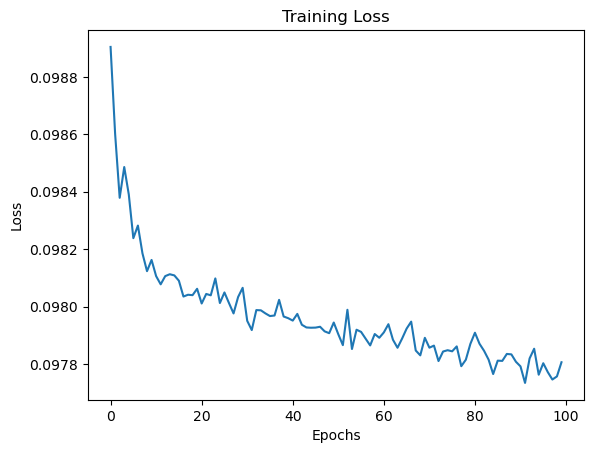

In [237]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

# Plot the training loss
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

The "epoch" represents a complete iteration of the training data, the "training loss" is the metric that quantifies the error during training, and the "loss" graph shows the variation of the loss over epochs.

In [240]:
# Get model predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Reshape the dimensions of y_train and y_test arrays
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Reshape the dimensions of train_predictions and test_predictions arrays
train_predictions = train_predictions.reshape(-1, 1)
test_predictions = test_predictions.reshape(-1, 1)

# Resize predictions to have the same number of samples as y_train and y_test
train_predictions = train_predictions[:len(y_train)]
test_predictions = test_predictions[:len(y_test)]

# Calculate MAE and MSE for training and test sets
train_mae = mean_absolute_error(y_train, train_predictions)
train_mse = mean_squared_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

# Display the results
print('Train Mean Absolute Error:', train_mae)
print('Train Mean Squared Error:', train_mse)
print('Test Mean Absolute Error:', test_mae)
print('Test Mean Squared Error:', test_mse)


94/94 [==============================] - 0s 2ms/step


ValueError: Found input variables with inconsistent numbers of samples: [27000, 3000]